In [185]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import os

In [186]:
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [187]:
def augment_images(input_folder, output_folder, n_augmented=26):
    os.makedirs(output_folder, exist_ok=True)
    
    for img_file in os.listdir(input_folder):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, img_file)
            img = load_img(img_path)
            x = img_to_array(img)    
            x = x.reshape((1,) + x.shape)  
            
            prefix = os.path.splitext(img_file)[0]
            i = 0
            
            for batch in augmenter.flow(x, batch_size=1,
                                        save_to_dir=output_folder,
                                        save_prefix=prefix,
                                        save_format='png'):
                i += 1
                if i >= n_augmented:
                    break

In [188]:
augment_images('Disease_Prediction/Healthy', 'dataset/train/Healthy', n_augmented=26)
augment_images('Disease_Prediction/Parkinsons', 'dataset/train/Parkinsons', n_augmented=26)

In [189]:
import os
import random
import shutil

def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)

    split_index = int(len(files) * split_ratio)
    train_files = files[:split_index]
    val_files = files[split_index:]

    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, f))

base_dir = 'dataset/train'

split_data(f'{base_dir}/Healthy', 'dataset/train_split/Healthy', 'dataset/val_split/Healthy')
split_data(f'{base_dir}/Parkinsons', 'dataset/train_split/Parkinsons', 'dataset/val_split/Parkinsons')


In [190]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [191]:
train_dir = "dataset/train_split"
val_dir = "dataset/val_split"

In [192]:
img_size=128
batch_size=1

In [193]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

Found 124 files belonging to 2 classes.
Found 32 files belonging to 2 classes.


In [194]:
import os

train_healthy = len(os.listdir('dataset/train_split/Healthy'))
train_parkinsons = len(os.listdir('dataset/train_split/Parkinsons'))

val_healthy = len(os.listdir('dataset/val_split/Healthy'))
val_parkinsons = len(os.listdir('dataset/val_split/Parkinsons'))

print(f"Train:\nHealthy: {train_healthy} images\nParkinsons: {train_parkinsons} images\n")
print(f"Validation:\nHealthy: {val_healthy} images\nParkinsons: {val_parkinsons} images\n")


Train:
Healthy: 62 images
Parkinsons: 62 images

Validation:
Healthy: 16 images
Parkinsons: 16 images



In [195]:
import os

print("train_dir exists:", os.path.isdir(train_dir))
print("Contents of train_dir:", os.listdir(train_dir))


train_dir exists: True
Contents of train_dir: ['Healthy', 'Parkinsons']


In [196]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [197]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [198]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [205]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [206]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4972 - loss: 1.0737 - val_accuracy: 0.7500 - val_loss: 0.5659
Epoch 2/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6219 - loss: 0.5766 - val_accuracy: 0.7188 - val_loss: 0.5018
Epoch 3/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6409 - loss: 0.5944 - val_accuracy: 0.7500 - val_loss: 0.3607
Epoch 4/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7238 - loss: 0.4593 - val_accuracy: 0.8750 - val_loss: 0.2794
Epoch 5/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7783 - loss: 0.4347 - val_accuracy: 0.8750 - val_loss: 0.3350
Epoch 6/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6844 - loss: 0.4892 - val_accuracy: 0.7812 - val_loss: 0.4378
Epoch 7/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6470 - loss: 0.5438 - val_accuracy: 0.8750 - val_loss: 0.4263
Epoch 8/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7381 - loss: 0.4225 - val_accuracy: 0.

Text(0.5, 1.0, 'Accuracy')

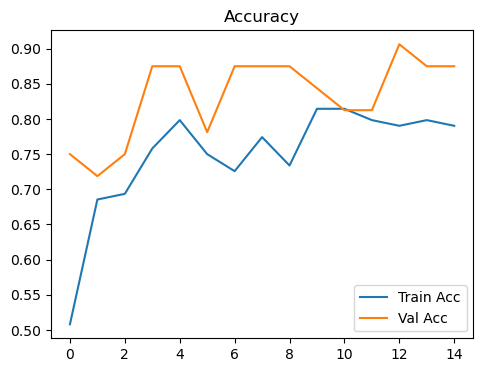

In [201]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

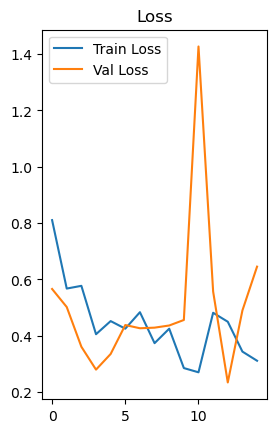

In [202]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [203]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.round(preds).flatten() 
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Parkinsons']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━

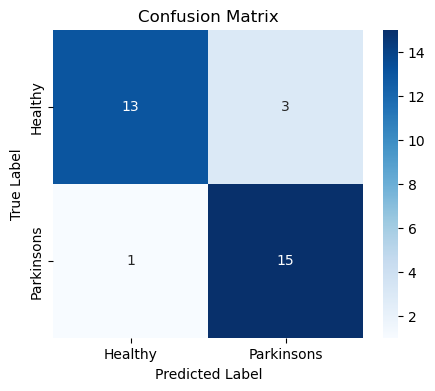

In [204]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinsons'], yticklabels=['Healthy', 'Parkinsons'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()